In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import sys
import os
from abc import ABC, abstractmethod

sys.path.append(os.path.abspath("../src"))

import race_course
import utils
from utils import Conversions
from pacing_plan import *

In [90]:
def set_negatives_to_zero(arr):
    return np.where(arr < 0, 0, arr)

In [226]:
class PacingPlanSegmenting(PacingPlan):
    def __init__(self, race_course, target_time, total_paces):
        super().__init__(race_course, target_time, total_paces)

    def optimal_segment_pace(self, start, end):
        distances = self.get_distances()
        total_distance = sum(distances[start:end+1])
        total_time = self.optimal_paces[start:end+1] @ distances[start:end+1]
        return total_time/total_distance
        
    def _calculate_recommendations(self, verbose):
        course = self.race_course
        course.smoothen_segments(smoothen="gaussian")
        min_hill_distance = 350*METERS_TO_MILES
        min_hill_height = 30
        
        uphills, downhills = detect_hills(course.grades, course.start_distances, course.end_distances, course.elevations, 2, 3, min_hill_distance, min_hill_height)
        segments = get_spanning_segments(course.distances, course.elevations*Conversions.FEET_TO_MILES.value, uphills, downhills, .25)
        self.segments = segments
        for segment in segments:
            start = segment[0]
            end = segment[1]
            self.true_paces_full[start:end+1] = self.optimal_segment_pace(start, end)
        return self.true_paces_full

Segment: (297, 311), Height: 13.97122514807722, Min Height: 30


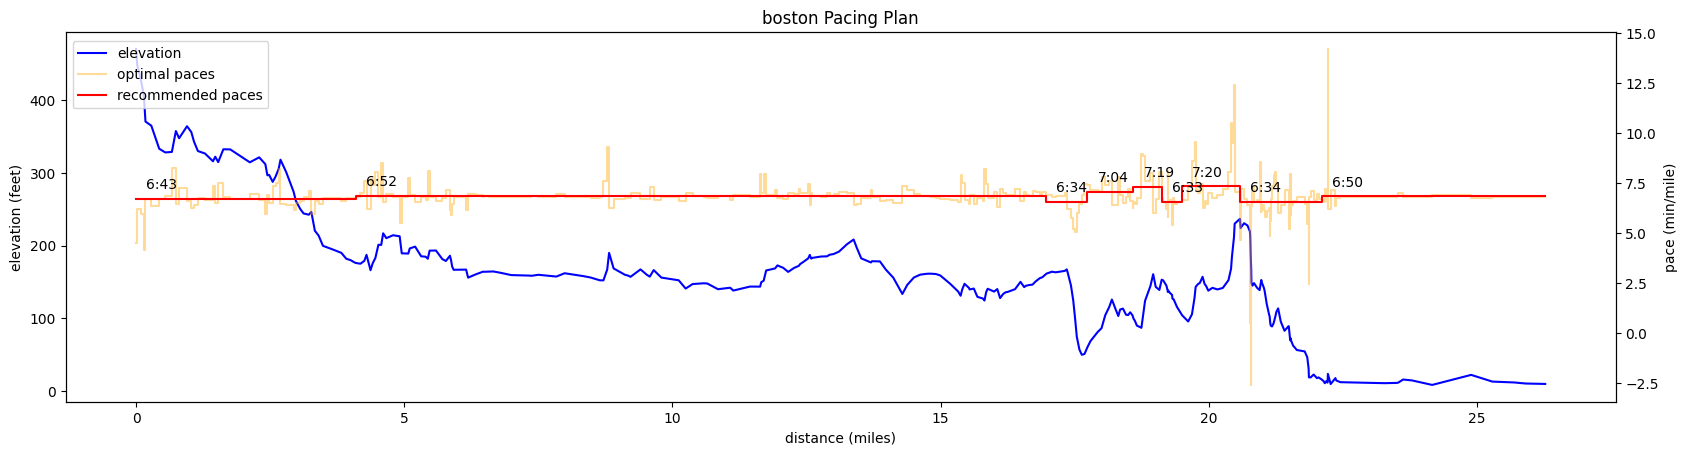

In [249]:
file_path = "../data/boston.gpx"
course_name = os.path.basename(file_path).split('.')[0]
course = race_course.RealRaceCourse(course_name, file_path)
segmenting_plan = PacingPlanSegmenting(course, 180, 6)
segmenting_plan.calculate_recommendations()
segmenting_plan.gen_pace_chart('../results/segmenting_plan.png', incl_opt_paces=True)

In [250]:
segmenting_plan.true_total_time

180.00000000000006

[(0, 45),
 (46, 180),
 (181, 193),
 (194, 208),
 (209, 218),
 (219, 229),
 (230, 250),
 (251, 296),
 (297, 316)]

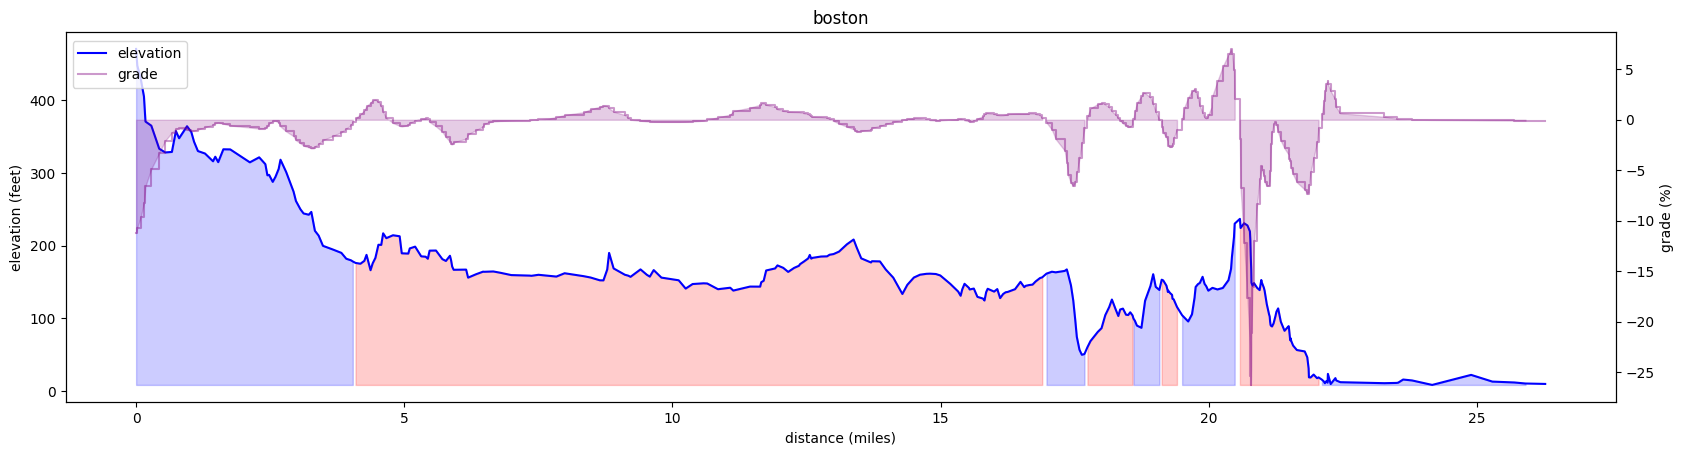

In [251]:
segments = segmenting_plan.segments
uphills = []
downhills = []
for i, segment in enumerate(segments):
    if i%2 == 0:
        uphills.append(segment)
    else:
        downhills.append(segment)

gen_course_plot(course, None, uphills, downhills)
segments

In [115]:
def filter_short_segments(segments, min_length, start_distances, end_distances):
    return [(start, end) for start, end in segments if end_distances[end] - start_distances[start] >= min_length]

def filter_short_hills(segments, min_height, elevations):
    result = [(start, end) for start, end in segments if max(elevations[start:end+1]) - min(elevations[start:end+1]) >= min_height]
    for segment in segments:
        if segment not in result:
            start = segment[0]
            end = segment[1]
            print(f'Segment: {segment}, Height: {max(elevations[start:end+1]) - min(elevations[start:end+1])}, Min Height: {min_height}')
    return result
    
def detect_hills(grades, start_distances, end_distances, elevations, uphill_cutoff, downhill_cutoff, min_length, min_height):    
    significant_uphills = (grades >= uphill_cutoff)
    significant_downhills = (grades <= -downhill_cutoff)

    uphill_segments = find_continuous_segments(significant_uphills, grades)
    downhill_segments = find_continuous_segments(significant_downhills, -grades)
    
    filtered_uphill_segments = filter_short_segments(uphill_segments, min_length, start_distances, end_distances)
    filtered_downhill_segments = filter_short_segments(downhill_segments, min_length, start_distances, end_distances)
    
    filtered_uphill_segments = filter_short_hills(filtered_uphill_segments, min_height, elevations)
    filtered_downhill_segments = filter_short_hills(filtered_downhill_segments, min_height, elevations)

    return filtered_uphill_segments, filtered_downhill_segments

In [116]:
def adjust_point(index, grades, coeff=1):
    adjusted_point = index
    n = len(grades)
    while adjusted_point > 0 and adjusted_point < n-1 and grades[adjusted_point + coeff] >= 0:
        adjusted_point += coeff
    return adjusted_point
    
def find_continuous_segments(hills, grades):
    segments = []
    start = None
    n = len(hills)
    i = 0
    
    while i < n:
        is_significant = hills[i]
        if is_significant:
            if start is None:
                start = i
            i += 1
        else:
            i += 1
            if start is not None:
                adjusted_start = adjust_point(start, grades, -1)
                adjusted_end = adjust_point(i - 2, grades, 1)
                
                segments.append((adjusted_start, adjusted_end))
                start = None
                i = adjusted_end + 1
                
    if start is not None:
        adjusted_start = adjust_point(start, grades, -1)
        adjusted_end = n - 1
        segments.append((adjusted_start, adjusted_end))

    return segments

In [117]:
def gen_course_plot(course, file_path, uphills=None, downhills=None):
    fig, ax = plt.subplots()
    fig.set_figwidth(20)
    
    # Define distance and elevation data
    distances = np.insert(course.end_distances, 0, 0)
    full_elevations = np.append(course.elevations, course.end_elevations[-1])
    min_elevation = np.min(full_elevations)
    
    # Plot elevation profile
    ax.plot(distances, full_elevations, label='elevation', color='blue')
    ax.set_xlabel('distance (miles)')
    ax.set_ylabel('elevation (feet)')
    
    # Define secondary y-axis for grade
    ax2 = ax.twinx()
    ax2.set_ylabel('grade (%)')
    full_grades = np.append(course.grades, course.grades[-1])
    ax2.step(distances, full_grades, label='grade', color='purple', where='post', alpha=0.4)
    
    # Highlight specified segments, if any
    if uphills:
        for (start_idx, end_idx) in uphills:
            start_dist = distances[start_idx]
            end_dist = distances[end_idx]
            
            # Highlight elevation in blue with reduced opacity
            ax.fill_between(distances[start_idx:end_idx+1], 
                            min_elevation, 
                            full_elevations[start_idx:end_idx+1], 
                            color='blue', alpha=0.2)
            
            # Highlight grade in purple with reduced opacity on the secondary y-axis
            ax2.fill_between(distances[start_idx:end_idx+1], 
                             full_grades[start_idx:end_idx+1], 
                             color='purple', alpha=0.2)
    
    if downhills:
        for (start_idx, end_idx) in downhills:
            start_dist = distances[start_idx]
            end_dist = distances[end_idx]
            
            # Highlight elevation in blue with reduced opacity
            ax.fill_between(distances[start_idx:end_idx+1], 
                            min_elevation, 
                            full_elevations[start_idx:end_idx+1], 
                            color='red', alpha=0.2)
            
            # Highlight grade in purple with reduced opacity on the secondary y-axis
            ax2.fill_between(distances[start_idx:end_idx+1], 
                             full_grades[start_idx:end_idx+1], 
                             color='purple', alpha=0.2)
    
    # Add legend and title
    fig.legend(loc="upper left", bbox_to_anchor=(0.125, 0.875))
    ax.set_title(course.course_name)
    
    # Save the plot
    #plt.savefig(file_path, bbox_inches='tight', dpi=300)

In [218]:
def calculate_segment_grade(start, end, elevations, distances):
    distance = sum(distances[start:end+1])
    elevation = sum(elevations[start:end+1])
    return 100*elevation/distance

def get_spanning_segments(distances, elevations, uphill_segments, downhill_segments, min_segment_length):
    all_segments = sorted(uphill_segments + downhill_segments, key=lambda x: x[0])
    full_course_segments = []
    filler_segments = []
    total_segments = len(distances)
    
    current_start = 0
    for (start, end) in all_segments:
        if current_start < start:
            full_course_segments.append((current_start, start - 1))
            filler_segments.append((current_start, start - 1))
        full_course_segments.append((start, end))        
        current_start = end + 1
    if current_start < total_segments:
        full_course_segments.append((current_start, total_segments - 1))
        filler_segments.append((current_start, total_segments - 1))

    return merge_filler_segments(distances, elevations, filler_segments, full_course_segments, min_segment_length)

def merge_filler_segments(distances, elevations, filler_segments, full_course_segments, min_segment_length):
    merged_segments = []
    remove_next_segment = False
    for i, (start, end) in enumerate(full_course_segments):
        if (start, end) in filler_segments:
            segment_distance = sum(distances[start:end+1])
            if segment_distance < min_segment_length:
                prev_segment = full_course_segments[i-1] if i > 0 else None
                next_segment = full_course_segments[i+1] if i < len(full_course_segments) - 1 else None

                segment_grade = calculate_segment_grade(start, end, elevations, distances)
                prev_grade = calculate_segment_grade(prev_segment[0], prev_segment[1], elevations, distances) if prev_segment else None
                next_grade = calculate_segment_grade(next_segment[0], next_segment[1], elevations, distances) if next_segment else None

                prev_grade_distance = abs(prev_grade - segment_grade) if prev_segment else None
                next_grade_distance = abs(next_grade - segment_grade) if next_segment else None
                
                # Merge with the more similar adjacent segment
                if prev_segment and (prev_grade_distance <= next_grade_distance or not next_segment):
                    merged_segments[-1] = (prev_segment[0], end)
                elif next_segment:
                    merged_segments.append(start, next_segment[1]) # Assume next segment is not in filler
                    remove_next_segment = True
                else:
                    merged_segments.append((start, end))
            else:
                merged_segments.append((start, end))
        else:
            if remove_next_segment:
                remove_next_segment = False
            else:
                merged_segments.append((start, end))
    return merged_segments

In [256]:
file_path = "../data/boston.gpx"
course_name = os.path.basename(file_path).split('.')[0]
course = race_course.RealRaceCourse(course_name, file_path)
course.smoothen_segments(smoothen="gaussian")
course.grades

array([-1.12122480e+01, -1.06803707e+01, -9.65976765e+00, -8.24323999e+00,
       -6.57847684e+00, -4.85928637e+00, -3.29587657e+00, -2.06699453e+00,
       -1.27171871e+00, -9.02495437e-01, -8.55239269e-01, -9.68756190e-01,
       -1.08312598e+00, -1.09132999e+00, -9.62961342e-01, -7.38267123e-01,
       -4.98747818e-01, -3.30263814e-01, -2.88671937e-01, -3.83082958e-01,
       -5.70218041e-01, -7.66810901e-01, -8.77511146e-01, -8.35922086e-01,
       -6.40623524e-01, -3.67847450e-01, -1.45741272e-01, -9.76665363e-02,
       -2.82508652e-01, -6.68373861e-01, -1.15484527e+00, -1.63054247e+00,
       -2.02584905e+00, -2.32956823e+00, -2.56296190e+00, -2.73856399e+00,
       -2.83789750e+00, -2.82352525e+00, -2.66903953e+00, -2.38484982e+00,
       -2.01521904e+00, -1.61635438e+00, -1.22953244e+00, -8.70493227e-01,
       -5.31560795e-01, -1.94811450e-01,  1.57218490e-01,  5.35656358e-01,
        9.38787300e-01,  1.34460365e+00,  1.70408578e+00,  1.94506257e+00,
        1.99138628e+00,  

In [257]:
METERS_TO_FEET = 3.28084
METERS_TO_MILES = 0.0006213712
min_distance = 350*METERS_TO_MILES
min_height = 30
uphills, downhills = detect_hills(course.grades, course.start_distances, course.end_distances, course.elevations, 2, 3, min_distance, min_height)
get_spanning_segments(course.distances, course.elevations*Conversions.FEET_TO_MILES.value, uphills, downhills, .25)

Segment: (297, 311), Height: 13.97122514807722, Min Height: 30


[(0, 45),
 (46, 180),
 (181, 193),
 (194, 208),
 (209, 218),
 (219, 229),
 (230, 250),
 (251, 296),
 (297, 316)]

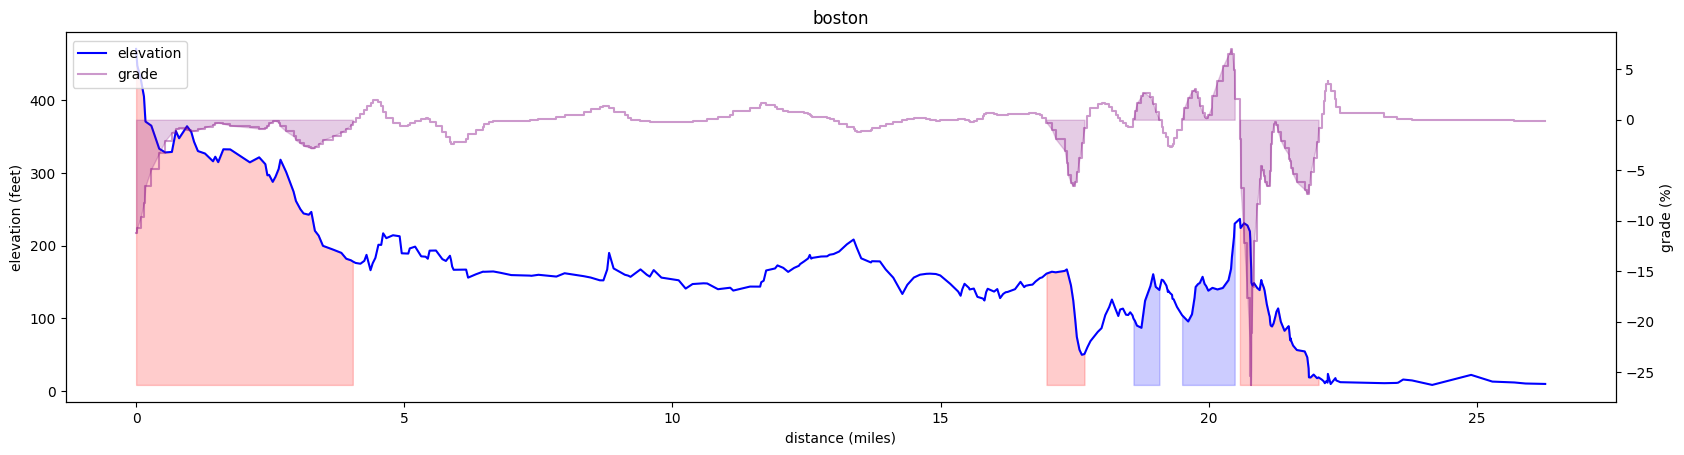

In [258]:
gen_course_plot(course, None, uphills, downhills)

In [184]:
def get_segment_data(start, end, elevations, distances, grades):
    elevation = sum(elevations[start:end+1])
    distance = sum(distances[start:end+1])
    grade = 100*elevation / distance
    area = grades[start:end+1] @ distances[start:end+1]
    return grade, distance, distance*grade, area

elevations = course.elevation_changes*Conversions.FEET_TO_MILES.value
distances = course.distances
grades = course.grades
get_segment_data(139, 160, elevations, distances, grades)

(-2.042626206790599,
 1.3506578225084076,
 -2.758889064662399,
 -1.464822506663794)

In [158]:
# Boston
print(get_segment_data(0, 59, elevations, distances, grades), 'Down')
print(get_segment_data(59, 184, elevations, distances, grades), 'Flat')
print(get_segment_data(185, 191, elevations, distances, grades), 'Down')
print(get_segment_data(192, 250, elevations, distances, grades), 'Up')
print(get_segment_data(250, 292, elevations, distances, grades), 'Down')
print(get_segment_data(292, len(distances)-1, elevations, distances, grades), 'Flat')
print(get_segment_data(0, len(distances)-1, elevations, distances, grades), 'Flat')

(-1.0511656072304842, 5.074945438770678, -5.334608103806956, -7.044971108369245) Down
(-0.03384426446774329, 12.401296279754193, -0.41971275103484185, 0.11421844871749898) Flat
(-7.941343511855743, 0.2801578119808896, -2.224829422470139, -1.515824470508227) Down
(1.201701426501641, 2.9480718837350937, 3.542702188113842, 3.512107262018099) Up
(-2.833755791102385, 1.4147064867816082, -4.008932699627492, -8.662569262259424) Down
(-0.03906017331189585, 4.4057800373070215, -0.17209053183130324, 0.4656451257459432) Flat
(-0.3323418816087941, 26.275847442034102, -8.732564579751232, -13.058139455682864) Flat


In [174]:
get_segment_data(218, 230, elevations, distances, grades)

(-1.547057795991342,
 0.46324831290336266,
 -0.7166719139569838,
 -0.6255412140406627)

In [60]:
len(distances)

155

In [63]:
# Scurve
elevations = course.elevation_changes*Conversions.FEET_TO_MILES.value
distances = course.distances
print(get_segment_data(0, 56, elevations, distances), 'Up')
print(get_segment_data(59, 131, elevations, distances), 'Down')
print(get_segment_data(0, len(distances)-1, elevations, distances), 'Flat')

(3.0878497580964006, 0.7687028112826643, 2.373638789867198) Up
(-1.7197441797693087, 1.4850095317015, -2.5538364990456013) Down
(0.009788022108724648, 2.539313475420618, 0.02485485643839943) Flat


10.0